# Survival impact of InstaPrism cell-type fractions in Schildkraut HGSOC

This analysis investigates the prognostic impact of intratumoral cellular composition on survival outcomes in high-grade serous ovarian cancer (HGSOC). Using multivariable Cox proportional hazards models, we evaluate whether the abundance of adipocytes, stromal cells, immune cells, and epithelial cells within tumors is associated with overall mortality. Hazard ratios, confidence intervals, and p-values are reported for both complete-case and reduced-covariate models to assess robustness. The analysis further considers surgical variables such as bulky residual disease, allowing us to determine which tumor-intrinsic and clinical features independently predict patient survival.

**Results** 

Adipocyte abundance was a strong, independent predictor of poor survival in HGSOC, with each 10% increase in intratumoral adipocyte content raising mortality risk by about 25%, a finding consistent across statistical models. In contrast, age showed only a weak trend, while BMI, race, stromal, immune, and epithelial cell proportions had no significant impact. The only other strong predictor was bulky residual disease after surgery, which increased the hazard of death by 50%. Overall, adipocytes uniquely captured a tumor-intrinsic feature linked to worse outcomes.

In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from sklearn.model_selection import ParameterGrid
import numpy as np, pandas as pd
from lifelines.utils import k_fold_cross_validation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid, KFold
import os
from sklearn.preprocessing import StandardScaler
from matplotlib_venn import venn2
import sys

sys.path.insert(1, "../../")
sys.path.insert(1, "../")

import src.hp as hp

pd.set_option("display.max_rows", 100)
plt.style.use("default")

np.random.seed(88)

In [2]:
cell_types_to_use = ["Adipocytes"]  # Adipocytes, Stromal, Immune, Epithelial

complete_case = False

In [3]:
map_stage = True
remove_unknown_stage = True
remove_999_BMI = True
kaplan_meier = True
remove_BMI_treat = False

## Paths

In [4]:
base_path = os.path.dirname(os.getcwd())
meta_path = os.path.join(base_path, "input_data/metadata.xlsx")

### Formatting for below plots, etc.

In [5]:
if complete_case:
    remove_treatment = False
    remove_pts_with_unknowns = True
    title_for_plot = f"{cell_types_to_use[0]}: Complete Case Model (n=268)"

else:
    remove_treatment = True
    remove_pts_with_unknowns = False
    title_for_plot = f"{cell_types_to_use[0]}: Reduced Covariate Model (n=566)"

In [6]:
## The order for the plots below
if remove_BMI_treat:
    desired_order = [
        "Age",
        "No Adj Tx.",
        "Race: Black",
        "Residual: < 1cm",
        "Residual: ≥ 1cm",
        "Residual: Unknown size",
    ]
else:
    desired_order = [
        "Age",
        "BMI",
        "No Adj Tx.",
        "Race: Black",
        "Residual: < 1cm",
        "Residual: ≥ 1cm",
        "Residual: Unknown size",
    ]
if remove_treatment:
    desired_order.remove("No Adj Tx.")
    desired_order.remove("Residual: < 1cm")
    desired_order.remove("Residual: ≥ 1cm")
    desired_order.remove("Residual: Unknown size")

desired_order

['Age', 'BMI', 'Race: Black']

In [7]:
# continuous covariates to keep “as is”
if remove_BMI_treat:
    cont_cols = ["Age"]
else:
    cont_cols = ["Age", "BMI"]

## Load InstaPrism cell-fraction tables (processed) and metadata

Proportions

In [8]:
props = pd.read_csv(
    os.path.join(base_path, "input_data/proportions_sch.csv"), index_col=0
)
props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,0.159171,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,0.113022,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.082561,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,0.157235,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,0.141568,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,0.135240,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,0.174205,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,0.114204,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,0.136146,SchildkrautW,20160X98,47937


In [9]:
## Which cell types to use
if cell_types_to_use == ["Immune"]:
    cell_types_to_use_grouped = [
        "B cells",
        "Mast cells",
        "T cells",
        "Monocytes",
        "Plasma cells",
        "NK cells",
        "DC",
        "pDC",
        "Macrophages",
        "ILC",
    ]
    desired_order = desired_order + ["Immune"]

elif cell_types_to_use == ["Stromal"]:
    cell_types_to_use_grouped = ["Fibroblasts", "Endothelial cells"]
    desired_order = desired_order + ["Stromal"]

elif cell_types_to_use == ["Adipocytes"]:
    cell_types_to_use_grouped = ["Adipocytes"]
    desired_order = desired_order + ["Adipocytes"]

elif cell_types_to_use == ["Epithelial"]:
    props["Epithelial"] = props["Epithelial cells"]
    cell_types_to_use_grouped = ["Epithelial"]
    desired_order = desired_order + ["Epithelial"]

props[cell_types_to_use[0]] = props[cell_types_to_use_grouped].sum(axis=1)

props[cell_types_to_use[0]] = props[cell_types_to_use[0]] * 10

props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,1.591710,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,1.130216,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.825608,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,1.572353,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,1.415675,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,1.352398,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,1.742051,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,1.142044,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,1.361460,SchildkrautW,20160X98,47937


In [10]:
# Keep only the columns of interest
keep_cols = cell_types_to_use + ["SampleID", "Dataset", "ID"]
props = props[keep_cols]

## Merge, encode categorical covariates

### Build the analysis table  (clinical + cell fractions)


In [11]:
renaming = hp.get_variable_renaming()
renaming.pop("tissue", None)

'Tissue'

Metadata

In [12]:
## Importing and renaming metadata

# ------------------------------ clinical columns -----------------
meta_full = (
    pd.read_excel(meta_path, sheet_name=0)
    .rename(columns=str.strip)
    .rename(columns=renaming)
)

meta_full = meta_full[renaming.values()]

meta_full["Stage"] = pd.to_numeric(meta_full["Stage"], errors="coerce")

meta_full["Event"] = meta_full["Event"].astype(int)
meta_full["Time-Days"] = meta_full["Time_Yrs"] * 365.22

meta_full

,ID,Age,Event,Time_Yrs,Stage,Race,Debulk,Hispanic,BMI,NeoTx,AdjTx,Residual,Time-Days
0,40143,63,1,8.739220,3,1,2.0,2,23.218229,2.0,1.0,4.0,3191.737824
1,41377,54,1,1.180014,3,1,2.0,2,17.428942,2.0,NaN,3.0,430.964599
2,41387,55,1,11.983573,3,2,1.0,2,45.470350,2.0,1.0,2.0,4376.640495
3,41391,60,1,4.993840,3,1,2.0,2,31.340800,2.0,NaN,3.0,1823.850185
4,41435,59,1,4.057495,3,1,NaN,2,23.922658,NaN,NaN,NaN,1481.878275
...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,3,2,NaN,2,28.349557,NaN,NaN,NaN,3543.432295
584,320012,66,0,11.767760,3,2,2.0,2,37.677475,2.0,1.0,4.0,4297.821147
585,320025,60,1,6.827869,3,2,2.0,2,38.740537,2.0,1.0,3.0,2493.674262
586,320043,57,1,1.553425,3,2,2.0,2,19.854802,2.0,1.0,4.0,567.341754


Filtering samples

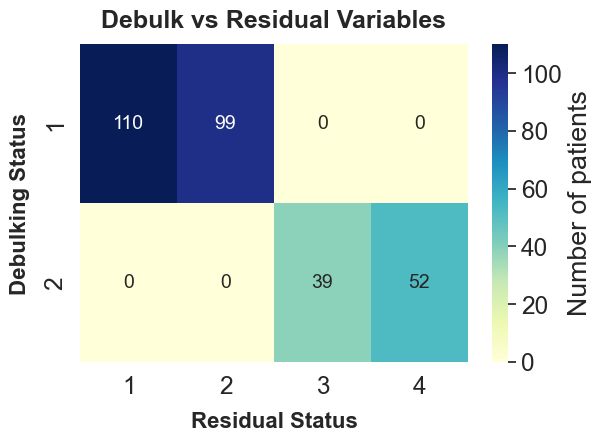

In [13]:
cross_tab = pd.crosstab(meta_full["Debulk"], meta_full["Residual"])
sns.set(style="white", font_scale=1.6)

ax = sns.heatmap(
    cross_tab,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    annot_kws={"fontsize": 14},
    cbar_kws={"label": "Number of patients"},
)

ax.set_title("Debulk vs Residual Variables", fontsize=18, pad=12, fontweight="bold")
ax.set_xlabel("Residual Status", fontsize=16, labelpad=10, fontweight="bold")
ax.set_ylabel("Debulking Status", fontsize=16, labelpad=10, fontweight="bold")
ax.set_xticklabels([1, 2, 3, 4])
ax.set_yticklabels([1, 2])
plt.tight_layout()
plt.show()

In [14]:
if remove_unknown_stage:
    first = meta_full.shape[0]
    meta_full = meta_full[meta_full["Stage"] != 9]
    print("Removed for unknown stage: ", first - meta_full.shape[0])

if remove_999_BMI:
    first = meta_full.shape[0]
    meta_full = meta_full[meta_full["BMI"] != 999]
    print("Removed for BMI 999: ", first - meta_full.shape[0])

# In no case we'd use Hispanic variable:
meta_full.drop(columns=["Hispanic"], inplace=True)

# We are removing debulking treatment that includes CA125.
meta_full.drop(columns=["Debulk"], inplace=True)

meta_full.drop(columns=["NeoTx"], inplace=True)

meta_full

Removed for unknown stage:  9
Removed for BMI 999:  13


,ID,Age,Event,Time_Yrs,Stage,Race,BMI,AdjTx,Residual,Time-Days
0,40143,63,1,8.739220,3,1,23.218229,1.0,4.0,3191.737824
1,41377,54,1,1.180014,3,1,17.428942,NaN,3.0,430.964599
2,41387,55,1,11.983573,3,2,45.470350,1.0,2.0,4376.640495
3,41391,60,1,4.993840,3,1,31.340800,NaN,3.0,1823.850185
4,41435,59,1,4.057495,3,1,23.922658,NaN,NaN,1481.878275
...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,3,2,28.349557,NaN,NaN,3543.432295
584,320012,66,0,11.767760,3,2,37.677475,1.0,4.0,4297.821147
585,320025,60,1,6.827869,3,2,38.740537,1.0,3.0,2493.674262
586,320043,57,1,1.553425,3,2,19.854802,1.0,4.0,567.341754


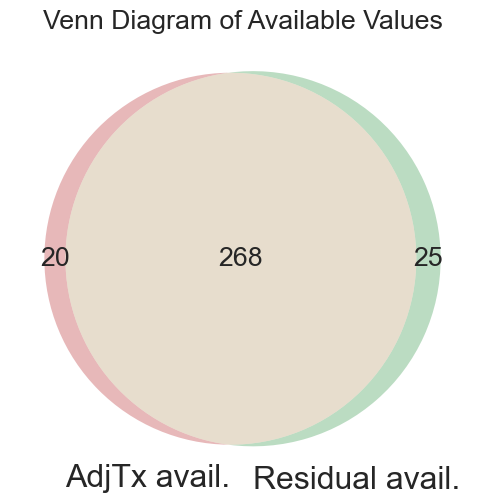

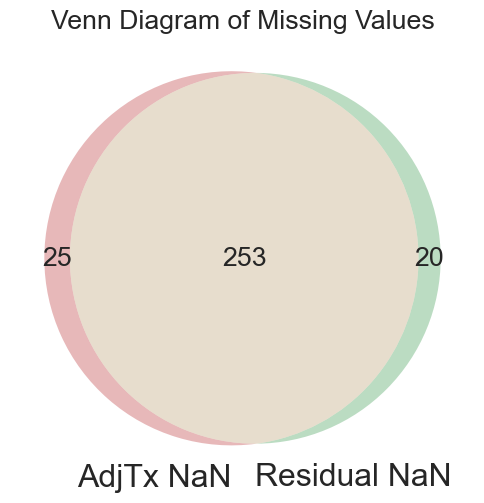

In [15]:
# Assume you already have the DataFrame `meta_full`
# Identify indices (rows) with NaNs in each column
nan_adjtx = set(meta_full[~meta_full["AdjTx"].isna()].index)
nan_residual = set(meta_full[~meta_full["Residual"].isna()].index)

# Create the Venn diagram
plt.figure(figsize=(6, 6))
venn2([nan_adjtx, nan_residual], set_labels=("AdjTx avail.", "Residual avail."))

plt.title("Venn Diagram of Available Values")
plt.show()

nan_adjtx = set(meta_full[meta_full["AdjTx"].isna()].index)
nan_residual = set(meta_full[meta_full["Residual"].isna()].index)

# Create the Venn diagram
plt.figure(figsize=(6, 6))
venn2([nan_adjtx, nan_residual], set_labels=("AdjTx NaN", "Residual NaN"))

plt.title("Venn Diagram of Missing Values")
plt.show()

In [16]:
# If we remove treatment we only keep Race and Stage of the categoricals.
if remove_treatment:
    cat_cols = ["Stage", "Race"]
    meta_full[cat_cols] = meta_full[cat_cols].astype("category")
    meta_full.columns
else:
    cat_cols = ["Stage", "Race", "Residual", "AdjTx"]
    meta_full[cat_cols] = meta_full[cat_cols].astype("category")
    meta_full.columns


if remove_BMI_treat:
    meta_full.drop(columns=["BMI"], inplace=True)

meta_full

,ID,Age,Event,Time_Yrs,Stage,Race,BMI,AdjTx,Residual,Time-Days
0,40143,63,1,8.739220,3,1,23.218229,1.0,4.0,3191.737824
1,41377,54,1,1.180014,3,1,17.428942,NaN,3.0,430.964599
2,41387,55,1,11.983573,3,2,45.470350,1.0,2.0,4376.640495
3,41391,60,1,4.993840,3,1,31.340800,NaN,3.0,1823.850185
4,41435,59,1,4.057495,3,1,23.922658,NaN,NaN,1481.878275
...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,3,2,28.349557,NaN,NaN,3543.432295
584,320012,66,0,11.767760,3,2,37.677475,1.0,4.0,4297.821147
585,320025,60,1,6.827869,3,2,38.740537,1.0,3.0,2493.674262
586,320043,57,1,1.553425,3,2,19.854802,1.0,4.0,567.341754


In [17]:
# ------------------------------ merge meta + props ----------------------------
# every SampleID maps to a unique suid)
analysis = props.merge(meta_full, on="ID", how="inner")

print(f"Using: {analysis.shape[0]} rows, {analysis['ID'].nunique()} patients")

analysis

Using: 566 rows, 566 patients


,Adipocytes,SampleID,Dataset,ID,Age,Event,Time_Yrs,Stage,Race,BMI,AdjTx,Residual,Time-Days
0,1.591710,18341X10,SchildkrautB,45369,53,1,2.004107,3,2,31.110562,1.0,3.0,731.939877
1,1.130216,18341X12,SchildkrautB,47261,57,1,5.240246,3,2,29.448927,NaN,NaN,1913.842793
2,0.825608,18341X13,SchildkrautB,47791,45,1,4.396988,3,2,40.981420,NaN,NaN,1605.868090
3,1.572353,18341X14,SchildkrautB,47916,68,1,2.151951,4,2,28.928061,NaN,NaN,785.935442
4,1.415675,18341X15,SchildkrautB,48002,44,1,1.508556,3,2,24.991295,1.0,2.0,550.954743
...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,1.352398,20160X95,SchildkrautW,47786,68,1,2.554415,3,1,31.538819,NaN,NaN,932.923367
562,1.742051,20160X96,SchildkrautW,47903,45,1,2.910335,3,1,20.410354,NaN,NaN,1062.912690
563,1.142044,20160X97,SchildkrautW,47926,52,0,14.414784,3,1,34.458370,NaN,NaN,5264.567555
564,1.361460,20160X98,SchildkrautW,47937,43,1,3.238877,3,1,20.156950,1.0,2.0,1182.902834


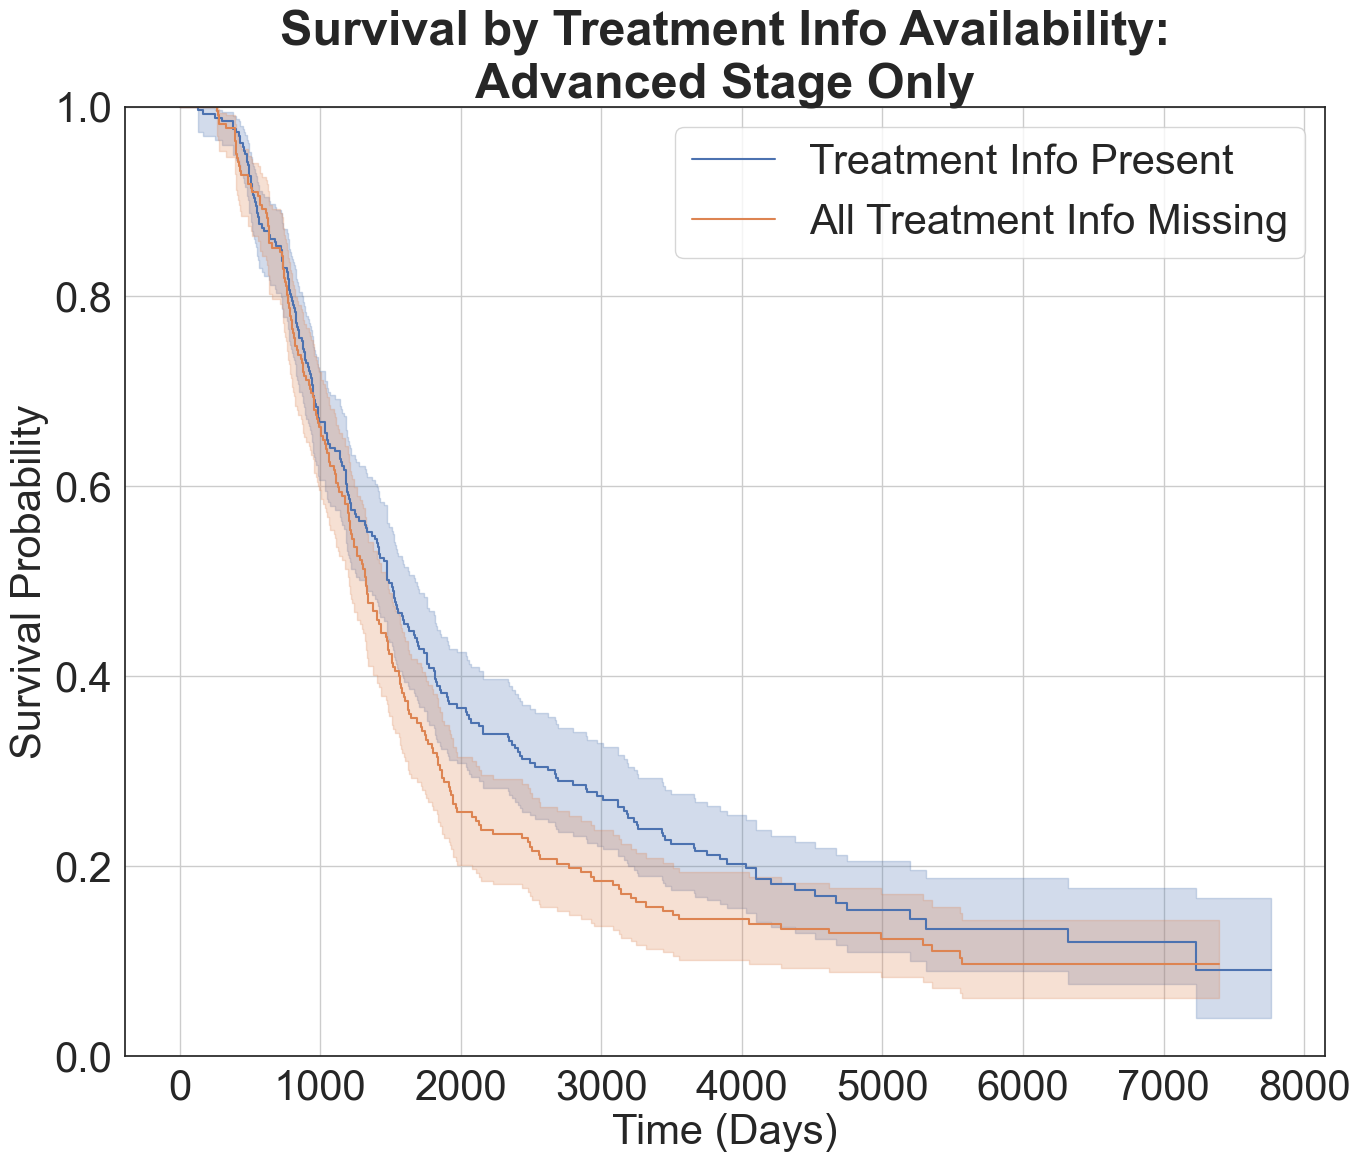

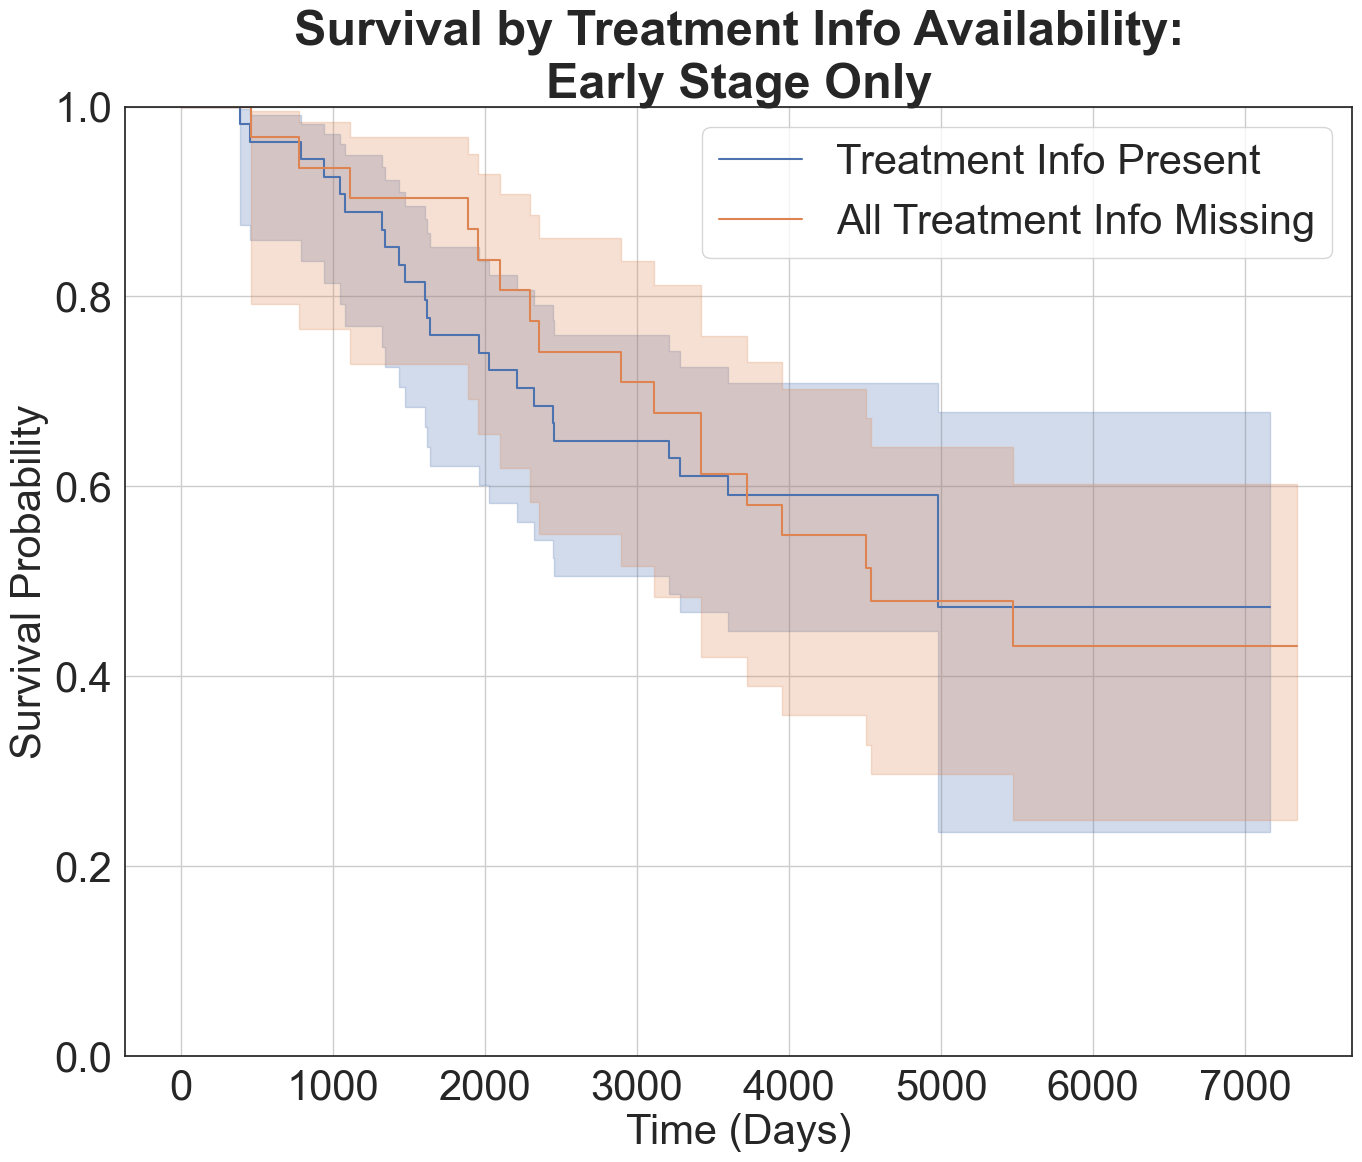

In [18]:
if kaplan_meier := False:
    # Kaplan-Meier survival analysis is not performed
    pass
else:
    # Define treatment columns
    treat_cols = ["AdjTx", "Residual"]

    # Create a new column indicating if all treatment info is missing
    analysis["all_treat_missing"] = analysis[treat_cols].isna().all(axis=1)

    # Define time and event columns (adjust names as needed)
    duration_col = "Time-Days"
    event_col = "Event"

    # Split the data into two groups
    has_info = analysis[~analysis["all_treat_missing"]]
    missing_info = analysis[analysis["all_treat_missing"]]

    hp.plot_km(
        has_info=has_info[has_info.Stage.isin([3, 4])],
        missing_info=missing_info[missing_info.Stage.isin([3, 4])],
        title="Survival by Treatment Info Availability:\nAdvanced Stage Only",
        duration_col=duration_col,
        event_col=event_col,
    )

    hp.plot_km(
        has_info=has_info[has_info.Stage.isin([1, 2])],
        missing_info=missing_info[missing_info.Stage.isin([1, 2])],
        title="Survival by Treatment Info Availability:\nEarly Stage Only",
        duration_col=duration_col,
        event_col=event_col,
    )
    analysis.drop(columns=["all_treat_missing"], inplace=True)

In [19]:
## Mapping the stage variable for stratification
if map_stage:
    stage_map = {1: 1, 2: 1, 3: 2, 4: 2}
    analysis["Stage"] = analysis.Stage.map(stage_map)

if remove_pts_with_unknowns:
    print("Going from: ", analysis.shape)
    analysis = analysis.dropna(subset=["Residual", "AdjTx"])
    print("To: ", analysis.shape)

analysis

,Adipocytes,SampleID,Dataset,ID,Age,Event,Time_Yrs,Stage,Race,BMI,AdjTx,Residual,Time-Days
0,1.591710,18341X10,SchildkrautB,45369,53,1,2.004107,2,2,31.110562,1.0,3.0,731.939877
1,1.130216,18341X12,SchildkrautB,47261,57,1,5.240246,2,2,29.448927,NaN,NaN,1913.842793
2,0.825608,18341X13,SchildkrautB,47791,45,1,4.396988,2,2,40.981420,NaN,NaN,1605.868090
3,1.572353,18341X14,SchildkrautB,47916,68,1,2.151951,2,2,28.928061,NaN,NaN,785.935442
4,1.415675,18341X15,SchildkrautB,48002,44,1,1.508556,2,2,24.991295,1.0,2.0,550.954743
...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,1.352398,20160X95,SchildkrautW,47786,68,1,2.554415,2,1,31.538819,NaN,NaN,932.923367
562,1.742051,20160X96,SchildkrautW,47903,45,1,2.910335,2,1,20.410354,NaN,NaN,1062.912690
563,1.142044,20160X97,SchildkrautW,47926,52,0,14.414784,2,1,34.458370,NaN,NaN,5264.567555
564,1.361460,20160X98,SchildkrautW,47937,43,1,3.238877,2,1,20.156950,1.0,2.0,1182.902834


In [20]:
for col in analysis:
    print(analysis[col].value_counts(dropna=False))

Adipocytes
1.591710    1
0.624160    1
2.321141    1
1.261022    1
0.897740    1
           ..
0.867091    1
1.215493    1
1.121835    1
1.877957    1
1.484585    1
Name: count, Length: 566, dtype: int64
SampleID
18341X10     1
20160X191    1
20160X186    1
20160X187    1
20160X188    1
            ..
19291X280    1
19291X279    1
19291X278    1
19291X277    1
20160X99     1
Name: count, Length: 566, dtype: int64
Dataset
SchildkrautW    303
SchildkrautB    263
Name: count, dtype: int64
ID
45369     1
43225     1
42710     1
42714     1
42912     1
         ..
190201    1
190197    1
190191    1
190183    1
47991     1
Name: count, Length: 566, dtype: int64
Age
57    30
63    30
56    25
64    25
59    22
55    20
53    18
71    18
60    18
50    18
67    18
52    18
62    16
54    16
51    16
70    16
61    16
58    15
73    15
49    14
66    14
68    14
45    14
65    13
72    13
69    13
48    12
47    12
74    11
44    10
46     9
43     9
42     6
40     6
39     5
77     4
78     

In [21]:
if remove_treatment:
    if remove_BMI_treat:
        cols = ["Age", "Event", "Time_Yrs", "Time-Days", "Stage", "Residual", "AdjTx"]
    else:
        cols = [
            "Age",
            "Event",
            "Time_Yrs",
            "BMI",
            "Time-Days",
            "Stage",
            "Residual",
            "AdjTx",
        ]

    cat_cols = ["Race"]
    # Get dummys for categorical columns with more than 2 cats (NaN counts as category)
    dummies = pd.get_dummies(
        analysis, columns=cat_cols, drop_first=True, prefix_sep="_"
    )
    dummies.drop(columns=props.columns, inplace=True)  # remove original proportions
    dummies.drop(columns=cols, inplace=True)  # remove original proportions
    dummies

else:
    if remove_BMI_treat:
        cols = ["Age", "Event", "Time_Yrs", "Time-Days", "Stage"]
    else:
        cols = ["Age", "Event", "Time_Yrs", "BMI", "Time-Days", "Stage"]

    cat_cols = ["Residual", "AdjTx", "Race"]
    # Get dummys for categorical columns with more than 2 cats (NaN counts as category)
    dummies = pd.get_dummies(
        analysis, columns=cat_cols, drop_first=True, prefix_sep="_"
    )
    dummies.drop(columns=props.columns, inplace=True)  # remove original proportions
    dummies.drop(columns=cols, inplace=True)  # remove original proportions
dummies

,Race_2
0,True
1,True
2,True
3,True
4,True
...,...
561,False
562,False
563,False
564,False


In [22]:
for col in dummies:
    print(dummies[col].value_counts(dropna=False))

Race_2
False    303
True     263
Name: count, dtype: int64


In [23]:
# Put together the analysis DataFrame
# (keep the original categorical columns for later use)
analysis_enc = pd.concat([analysis, dummies], axis=1)  # Columns that go into the model
cell_cols = props.columns.difference(["SampleID", "Dataset", "ID"])  # fractions
covars = cont_cols + list(dummies.columns) + list(cell_cols) + ["Stage"]

covars

['Age', 'BMI', 'Race_2', 'Adipocytes', 'Stage']

In [24]:
cox_df = analysis_enc[["Time-Days", "Event"] + covars].copy()

# and let's make names more interpretable:
if "AdjTx_2.0" in cox_df.columns:
    cox_df.rename(columns={"AdjTx_2.0": "No Adj Tx."}, inplace=True)
if "Race_2" in cox_df.columns:
    cox_df.rename(columns={"Race_2": "Race: Black"}, inplace=True)
if "Residual_4.0" in cox_df.columns:
    cox_df.rename(columns={"Residual_4.0": "Residual: Unknown size"}, inplace=True)
    cox_df.rename(columns={"Residual_3.0": "Residual: ≥ 1cm"}, inplace=True)
    cox_df.rename(columns={"Residual_2.0": "Residual: < 1cm"}, inplace=True)

In [25]:
print("Design matrix:", cox_df.shape)
print("Design matrix columns:", cox_df.columns)
cox_df

Design matrix: (566, 7)
Design matrix columns: Index(['Time-Days', 'Event', 'Age', 'BMI', 'Race: Black', 'Adipocytes',
       'Stage'],
      dtype='object')


,Time-Days,Event,Age,BMI,Race: Black,Adipocytes,Stage
0,731.939877,1,53,31.110562,True,1.591710,2
1,1913.842793,1,57,29.448927,True,1.130216,2
2,1605.868090,1,45,40.981420,True,0.825608,2
3,785.935442,1,68,28.928061,True,1.572353,2
4,550.954743,1,44,24.991295,True,1.415675,2
...,...,...,...,...,...,...,...
561,932.923367,1,68,31.538819,False,1.352398,2
562,1062.912690,1,45,20.410354,False,1.742051,2
563,5264.567555,0,52,34.458370,False,1.142044,2
564,1182.902834,1,43,20.156950,False,1.361460,2


### K-fold for model penalizer

Uses 5-fold cross-validation to evaluate model performance, using concordance index (a standard survival metric).

In [26]:
cv_table, best, fails = hp.tune_cox_penalty(
    cox_df, duration_col="Time-Days", event_col="Event", strata="Stage", k=5  # or None
)

print("Best hyper-parameters:")
print(best)

print("\nTop 5 grid points:")
display(cv_table.head())

if not fails.empty:
    print("\nFailures:")
    display(fails)

/Users/ivicha/anaconda3/envs/env_deconv/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/Users/ivicha/anaconda3/envs/env_deconv/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/Users/ivicha/anaconda3/envs/env_deconv/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/Users/ivicha/anaconda3/envs/env_deconv/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to 

Best hyper-parameters:
{'l1_ratio': 0.0, 'penalizer': 0.1, 'c_index_mean': 0.5450922059235552, 'c_index_sd': 0.016207117124137492}

Top 5 grid points:


,l1_ratio,penalizer,c_index_mean,c_index_sd
4,0.0,0.100,0.545092,0.016207
1,0.0,0.001,0.545053,0.026864
3,0.0,0.050,0.543588,0.023648
5,0.0,0.200,0.543044,0.018258
6,0.0,0.300,0.540853,0.032153


In [27]:
cox_df

,Time-Days,Event,Age,BMI,Race: Black,Adipocytes,Stage
0,731.939877,1,53,31.110562,True,1.591710,2
1,1913.842793,1,57,29.448927,True,1.130216,2
2,1605.868090,1,45,40.981420,True,0.825608,2
3,785.935442,1,68,28.928061,True,1.572353,2
4,550.954743,1,44,24.991295,True,1.415675,2
...,...,...,...,...,...,...,...
561,932.923367,1,68,31.538819,False,1.352398,2
562,1062.912690,1,45,20.410354,False,1.742051,2
563,5264.567555,0,52,34.458370,False,1.142044,2
564,1182.902834,1,43,20.156950,False,1.361460,2


Iteration 1: norm_delta = 2.01e-01, step_size = 0.9500, log_lik = -2433.99148, newton_decrement = 9.23e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 7.04e-03, step_size = 0.9500, log_lik = -2425.13772, newton_decrement = 1.14e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.61e-04, step_size = 0.9500, log_lik = -2425.12631, newton_decrement = 3.01e-05, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.99e-08, step_size = 1.0000, log_lik = -2425.12628, newton_decrement = 2.22e-13, seconds_since_start = 0.0
Convergence success after 4 iterations.


model,lifelines.CoxPHFitter
duration col,'Time-Days'
event col,'Event'
penalizer,0.1
l1 ratio,0.0
strata,Stage
baseline estimation,breslow
number of observations,566
number of events observed,456
partial log-likelihood,-2425.13
time fit was run,2025-08-19 21:54:09 UTC


<Axes: xlabel='log(HR) (95% CI)'>

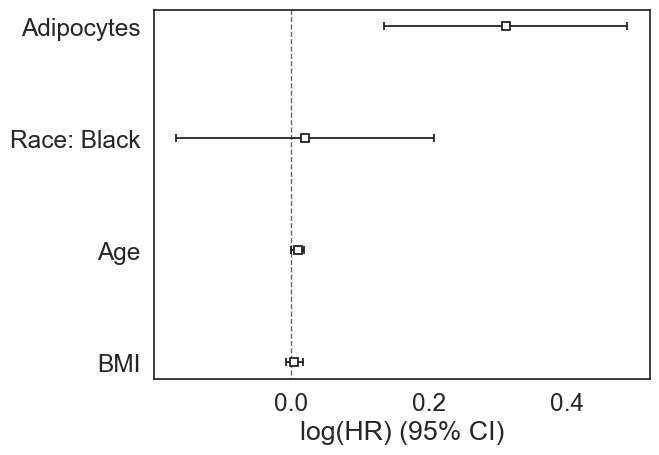

In [28]:
# ------------------------------ fit penalised CoxPH ------------------------------
# cph = CoxPHFitter()
cph = CoxPHFitter(penalizer=best["penalizer"], l1_ratio=best["l1_ratio"])

cph.fit(
    cox_df,
    show_progress=True,
    strata="Stage",
    duration_col="Time-Days",
    event_col="Event",
)

cph.print_summary(columns=["coef", "exp(coef)", "p", "z"])

cph.plot()

In [29]:
summary_small = (
    cph.summary[["exp(coef)", "p"]]
    .rename(columns={"exp(coef)": "HazardRatio", "p": "P-Value"})
    .reset_index()  # moves the index into a column
    .rename(columns={"covariate": "Covariate"})  # give that column a nicer name
)
summary_small["Model"] = title_for_plot

new_order = ["Model"] + [c for c in summary_small.columns if c != "Model"]
summary_small = summary_small[new_order]
# take a look
display(summary_small.style.hide(axis="index"))
summary_small.to_clipboard(index=False, excel=True)

Model,Covariate,HazardRatio,P-Value
Adipocytes: Reduced Covariate Model (n=566),Age,1.010534,0.026890
Adipocytes: Reduced Covariate Model (n=566),BMI,1.005442,0.373866
Adipocytes: Reduced Covariate Model (n=566),Race: Black,1.020982,0.827221
Adipocytes: Reduced Covariate Model (n=566),Adipocytes,1.365004,0.000536


In [30]:
# Full table
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Age,0.010479,1.010534,0.004735,0.001199,0.019760,1.001199,1.019956,0.0,2.213109,0.026890,5.216779
BMI,0.005427,1.005442,0.006103,-0.006534,0.017388,0.993487,1.017540,0.0,0.889256,0.373866,1.419409
Race: Black,0.020765,1.020982,0.095137,-0.165699,0.207229,0.847301,1.230265,0.0,0.218268,0.827221,0.273656
Adipocytes,0.311158,1.365004,0.089880,0.134996,0.487319,1.144532,1.627946,0.0,3.461916,0.000536,10.864554


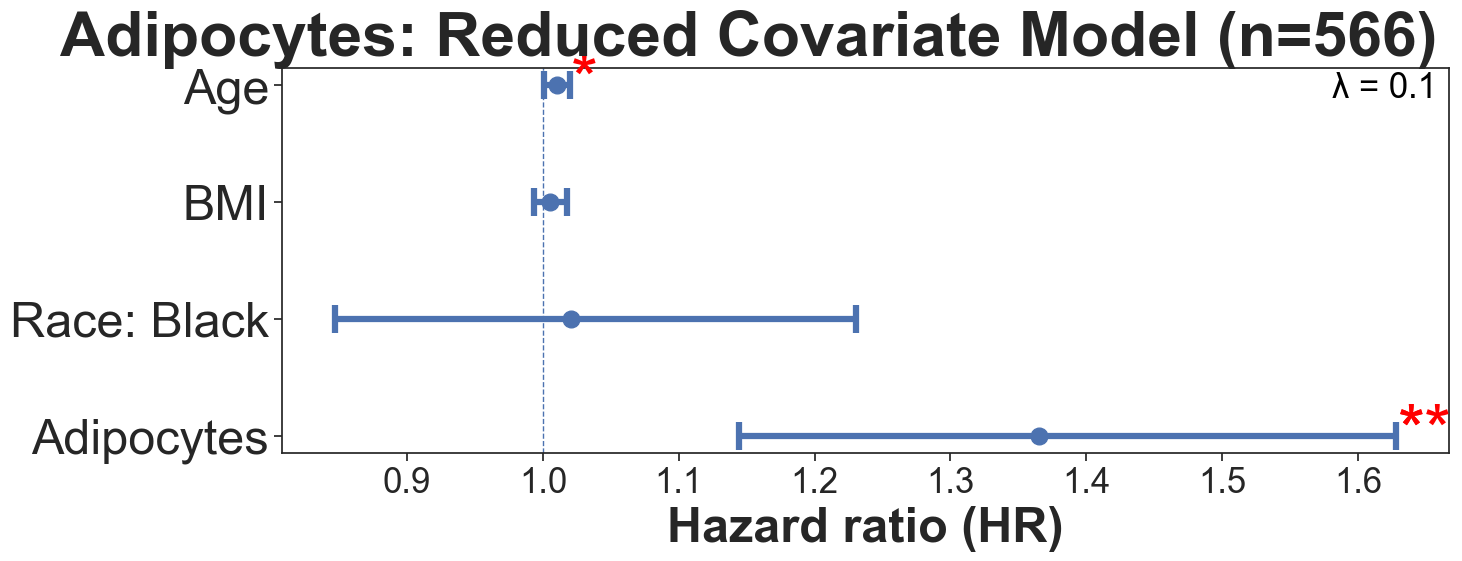

In [31]:
# ------------------------------------------------------------------
# 1. Pull the numbers we need, in a versiofn-agnostic way
# ------------------------------------------------------------------
sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})
summ = cph.summary.loc[desired_order].copy()

# locate the 95 % CI columns no matter what lifelines called them
ci_lower_col = [c for c in summ.columns if c.startswith("coef lower")][0]
ci_upper_col = [c for c in summ.columns if c.startswith("coef upper")][0]

summ["HR"] = np.exp(summ["coef"])
summ["lower95"] = np.exp(summ[ci_lower_col])
summ["upper95"] = np.exp(summ[ci_upper_col])

# ------------------------------------------------------------------
# 2. Plot on a *linear* x-axis
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 1.5 * len(summ)))
ypos = np.arange(len(summ))

ax.errorbar(
    x=summ["HR"],
    y=ypos,
    xerr=[summ["HR"] - summ["lower95"], summ["upper95"] - summ["HR"]],
    fmt="o",
    capsize=10,
    linewidth=4.5,
    elinewidth=4.5,
    capthick=4.5,
    markersize=12,
)

ax.axvline(1, ls="--", lw=1)

# mark p < 0.05 covariates with a star
# mark p < 0.05 covariates with a BIG star
for i, p in enumerate(summ["p"]):
    if p < 0.05:
        ax.text(
            summ["upper95"].iloc[i] * 1.001,
            ypos[i],
            "*",
            va="center",
            fontsize=50,
            color="red",
        )
    if p < 0.005:
        ax.text(
            summ["upper95"].iloc[i] * 1.001,
            ypos[i],
            "**",
            va="center",
            fontsize=50,
            color="red",
        )
    if p < 0.0005:
        ax.text(
            summ["upper95"].iloc[i] * 1.001,
            ypos[i],
            "***",
            va="center",
            fontsize=50,
            color="red",
        )
penalizer_decimals = hp.count_decimal_places(best["penalizer"])
if penalizer_decimals > 4:  ## If there is more than 4, we'll limit it at 4.
    penal = f"{best['penalizer']:.4f}"
else:  # Otherwise the full decimals
    penal = f"{best['penalizer']}"

ax.text(
    0.99,
    0.99,  # (x, y) in axes coordinates (near bottom right)
    f"λ = {penal}",
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=25,
    color="black",
)

ax.set_yticks(ypos)
ax.set_yticklabels(summ.index, fontsize=35)
plt.xticks(fontsize=25)
ax.set_ylabel("", fontsize=35)
ax.set_xlabel("Hazard ratio (HR)", fontsize=35, fontweight="bold")
ax.set_title(title_for_plot, fontsize=45, fontweight="bold", y=1.01, x=0.4)
ax.invert_yaxis()  # top row at the top
plt.tight_layout()
plt.show()

Now with log of the hazard ratio:

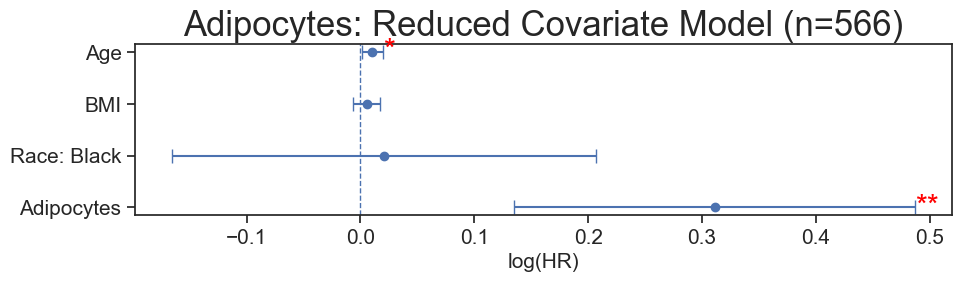

In [32]:
# ------------------------------------------------------------------
# 1. Pull the numbers we need, in a version-agnostic way
# ------------------------------------------------------------------
summ = cph.summary.loc[desired_order].copy()

# locate the 95 % CI columns no matter what lifelines called them
ci_lower_col = [c for c in summ.columns if c.startswith("coef lower")][0]
ci_upper_col = [c for c in summ.columns if c.startswith("coef upper")][0]

# log-scale columns (they’re already logs, but we rename for clarity)
summ["logHR"] = summ["coef"]
summ["lower95log"] = summ[ci_lower_col]
summ["upper95log"] = summ[ci_upper_col]

# ------------------------------------------------------------------
# 2. Plot on a *linear axis of log-HR*  (0 = HR 1)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 0.8 * len(summ)))
ypos = np.arange(len(summ))

ax.errorbar(
    x=summ["logHR"],
    y=ypos,
    xerr=[summ["logHR"] - summ["lower95log"], summ["upper95log"] - summ["logHR"]],
    fmt="o",
    capsize=5,
    linewidth=1.5,
)

# reference line at β = 0  (i.e., HR = 1)
ax.axvline(0, ls="--", lw=1)

# mark p < 0.05 covariates with stars of increasing size / count
for i, p in enumerate(summ["p"]):
    if p < 0.05:
        ax.text(
            summ["upper95log"].iloc[i] + 0.0003,  # small shift right
            ypos[i],
            "*" if p >= 0.005 else "**" if p >= 0.0005 else "***",
            va="center",
            fontsize=22,
            color="red",
        )

# ------------------------------------------------------------------
# 3. Styling
# ------------------------------------------------------------------
ax.set_yticks(ypos)
ax.set_yticklabels(summ.index, fontsize=15)
ax.set_ylabel("")
ax.set_xlabel("log(HR)", fontsize=15)
ax.set_title(title_for_plot, fontsize=25)
plt.xticks(fontsize=15)
ax.invert_yaxis()  # top row at the top
plt.tight_layout()
plt.show()

In [33]:
cph.check_assumptions(cox_df, p_value_threshold=0.05, show_plots=False)

Proportional hazard assumption looks okay.


[]

* **HR > 1** → Higher covariate value is associated with **shorter** survival.  
* **HR < 1** → Higher covariate value is associated with **longer** survival.